In [ ]:
"""
Inpainting CMB example
"""

In [ ]:
import numpy as np, sys, os, tools, scipy as sc, inpaint
import flatsky, tools
#%load_ext autoreload
#%autoreload 2

#%pylab notebook
%matplotlib inline
from pylab import *
from matplotlib import rc;rc('text', usetex=True);rc('font', weight='bold');matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
rcParams['figure.dpi'] = 150

In [3]:
#params or supply a params file
dx = 1.0
boxsize_am = 200. #boxsize in arcmins
nx = int(boxsize_am/dx)
mapparams = [nx, nx, dx, dx]
x1,x2 = -nx/2. * dx, nx/2. * dx
verbose = 0
#lmax = 10000
#el = np.arange(lmax)

#beam and noise levels
noiseval = 2.0 #uK-arcmin
beamval = 1.4 #arcmins

#CMB power spectrum
Cls_file = 'data/Cl_Planck2018_camb.npz'
#Tcmb = 2.73

#for inpainting
noofsims = 1000
mask_radius_inner = 4.0 #arcmins
mask_radius_outer = 20.0 #arcmins
mask_inner = 0  #If 1, the inner region is masked before the LPF. Might be useful in the presence of bright SZ signal at the centre.

In [4]:
#get ra, dec or map-pixel grid
ra = np.linspace(x1,x2, nx) #arcmins
dec = np.linspace(x1,x2, nx) #arcmins
ra_grid, dec_grid = np.meshgrid(ra,dec)

In [5]:
#read Cls now
#els, Dls = np.loadtxt(Cls_file, usecols = [0,1], unpack = 1)
Cls_rec = np.load(Cls_file, allow_pickle=1, mmap_mode='r')
#print(Cls_rec.files);sys.exit()
el = Cls_rec['L']
cl = Cls_rec['TT']* 1e12 #Cls in uK

#Dls_fac = els * (els + 1) / 2 / np.pi
#Cls = Cls * Dls_fac
print(len(el))

9051


In [6]:
#get beam and noise
bl = tools.get_bl(beamval, el, make_2d = 1, mapparams = mapparams)
nl = tools.get_nl(noiseval, el)

Text(0.5, 0, 'Multipole $\\ell$')

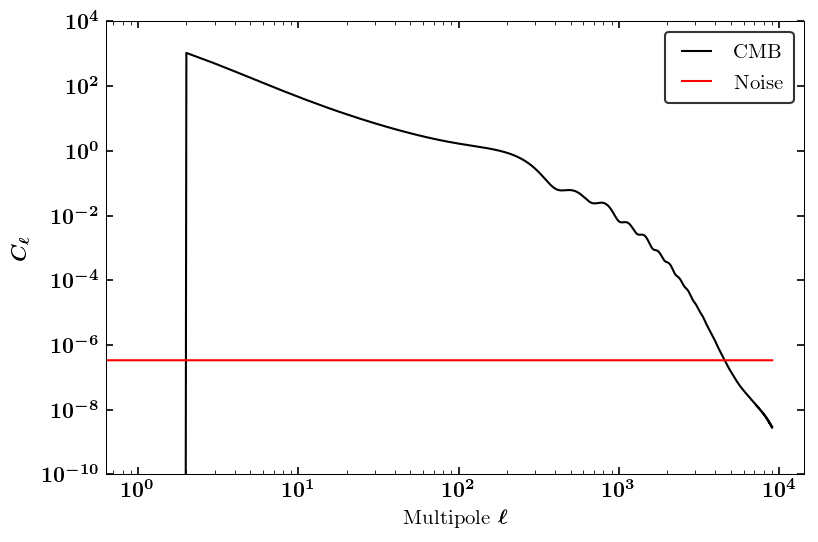

In [7]:
#plot
ax =subplot(111, yscale = 'log', xscale = 'log')
plot(el, cl, 'k-', label = r'CMB')
plot(el, nl, 'r-', label = r'Noise')
legend(loc = 1)
ylim(1e-10, 1e4)
ylabel(r'$C_{\ell}$')
xlabel(r'Multipole $\ell$')

Text(0.5, 1.0, 'CMB + Noise')

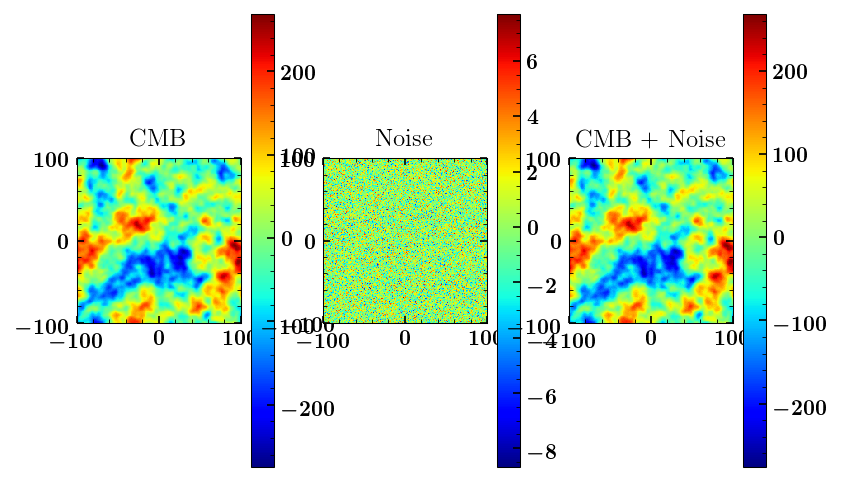

In [8]:
#create CMB and convolve with beam
cmb_map = tools.make_gaussian_realisation(mapparams, el, cl, bl = bl)

#noise map
noise_map = tools.make_gaussian_realisation(mapparams, el, nl)
sim_map = cmb_map + noise_map
subplot(131);imshow(cmb_map, extent = [x1,x2,x1,x2]); colorbar(); title(r'CMB')
subplot(132);imshow(noise_map, extent = [x1,x2,x1,x2]); colorbar(); title(r'Noise')
subplot(133);imshow(sim_map, extent = [x1,x2,x1,x2]); colorbar(); title(r'CMB + Noise')

In [9]:
#get covariance for inpainting
sigma_dic = inpaint.get_covariance(ra_grid, dec_grid, mapparams, el, cl, bl, nl, noofsims, mask_radius_inner, mask_radius_outer, low_pass_cutoff = 1)
print(sigma_dic.keys())


	calculating the covariance from simulations for inpainting

		generating 1000 sims

		covariance obtained
dict_keys(['sigma_22_inv', 'sigma_12'])


In [10]:
#perform inpainting
sim_map_inpainted, sim_map_filtered = inpaint.inpainting(sim_map, ra_grid, dec_grid, mapparams, el, cl, bl, nl, noofsims, mask_radius_inner, mask_radius_outer, low_pass_cutoff = 1, mask_inner = mask_inner, sigma_dic = sigma_dic)


	perform inpainting


Text(0.5, 1.0, 'Residual')

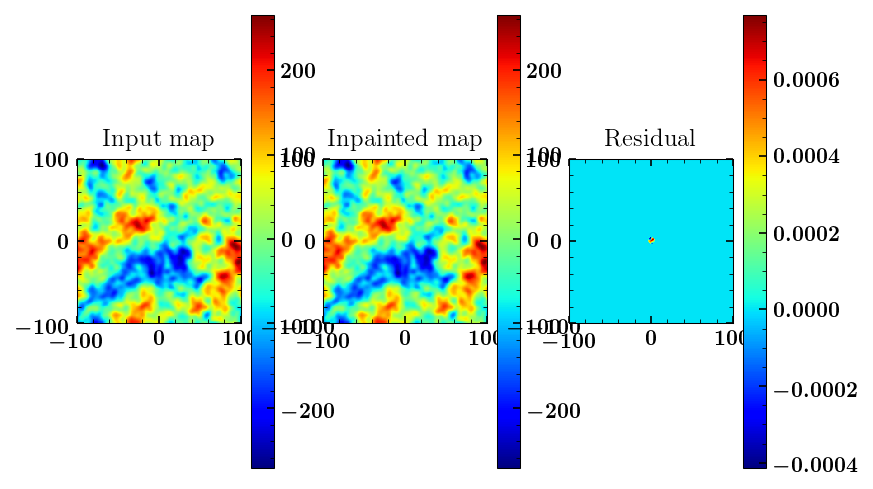

In [11]:
subplot(131);imshow(sim_map_filtered, extent = [x1,x2,x1,x2]); colorbar(); title(r'Input map')
subplot(132);imshow(sim_map_inpainted, extent = [x1,x2,x1,x2]); colorbar(); title(r'Inpainted map')
subplot(133);imshow(sim_map_filtered - sim_map_inpainted, extent = [x1,x2,x1,x2]); colorbar(); title(r'Residual')
